# 토크나이저

In [1]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "  which Harry watched fly around the room wishing he still had his fulls"

tokens = tokenizer.encode(text)

print("글자수 :", len(text))  # 글자수: 26
print("토큰수 :", len(tokens))  # 토큰수: 6
print(tokens)  # [15496, 2159, 257, 281, 3453, 13]
print(tokenizer.decode(tokens))  # Harry Potter was a wizard.
for token in tokens:
    print(token, ":", tokenizer.decode([token]))

글자수 : 72
토큰수 : 15
[220, 543, 5850, 7342, 6129, 1088, 262, 2119, 24433, 339, 991, 550, 465, 1336, 82]
  which Harry watched fly around the room wishing he still had his fulls
220 :  
543 :  which
5850 :  Harry
7342 :  watched
6129 :  fly
1088 :  around
262 :  the
2119 :  room
24433 :  wishing
339 :  he
991 :  still
550 :  had
465 :  his
1336 :  full
82 : s


In [2]:
from transformers import AutoTokenizer

# 1. GPT-2 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# 2. GPT-2는 기본 pad_token이 없어서 직접 설정
# if tokenizer.pad_token is None:
#     special_tokens_dict = {'pad_token': '<|pad|>'}
#     num_added = tokenizer.add_special_tokens(special_tokens_dict)

# pad를 따로 추가하지 말고, eos를 그대로 pad로 사용
tokenizer.pad_token = tokenizer.eos_token
pad_id = tokenizer.pad_token_id  # == eos_id

print("vocab_size:", tokenizer.vocab_size)
print("pad_token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)
print("eos_token:", tokenizer.eos_token, "id:", tokenizer.eos_token_id)

c:\github\llm\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


vocab_size: 50257
pad_token: <|endoftext|> id: 50256
eos_token: <|endoftext|> id: 50256


In [3]:
def load_text_samples(path: str):
    with open(path, "r", encoding="utf-8") as f:
        data = f.read().strip()
    # 샘플 사이에 빈 줄 하나 넣어놨으니까 "\n\n" 기준으로 자름
    samples = [s.strip() for s in data.split("\n\n") if s.strip()]
    return samples

train_samples = load_text_samples("lotto_train.txt")
print("샘플 개수:", len(train_samples))

example = train_samples[0]
print("원본 샘플:")
print(example)

샘플 개수: 100000
원본 샘플:
money=4000
winning=1,11,15,18,29,38
bonus=33
###
티켓수=4
구매번호:
[2,7,9,15,16,18]
[3,6,28,35,38,44]
[2,6,14,15,33,39]
[2,13,27,35,36,42]
3개일치 (5000원) = 0
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=0.0%


In [4]:
max_len = 512  # 임시

enc = tokenizer(
    example,
    max_length=max_len,
    padding="max_length",
    truncation=True,
    return_tensors="pt",  # PyTorch 텐서로
)

input_ids = enc["input_ids"]        # shape: (1, max_len)
attention_mask = enc["attention_mask"]  # shape: (1, max_len)

print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)

# 디코딩해서 잘 복원되는지 확인
decoded = tokenizer.decode(input_ids[0], skip_special_tokens=True)
print("디코딩된 텍스트:")
print(decoded)

input_ids shape: torch.Size([1, 512])
attention_mask shape: torch.Size([1, 512])
디코딩된 텍스트:
money=4000
winning=1,11,15,18,29,38
bonus=33
###
티켓수=4
구매번호:
[2,7,9,15,16,18]
[3,6,28,35,38,44]
[2,6,14,15,33,39]
[2,13,27,35,36,42]
3개일치 (5000원) = 0
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=0.0%


In [5]:
from torch.utils.data import Dataset
import torch

class LottoDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len: int, focus_len: int = 118):
        """
        focus_len: 시퀀스 뒤에서부터 몇 개 토큰을
                   '결과/수익률 구간'이라고 보고 가중치를 줄지
        """
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.eos = tokenizer.eos_token
        self.focus_len = focus_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        row_txt = self.texts[idx]

        txt = row_txt + self.eos

        # max_len+1 길이로 토큰화 → x:[:-1], y:[1:] 사용
        enc = self.tokenizer(
            txt,
            max_length=self.max_len + 1,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        ids = enc["input_ids"][0]           # (max_len+1,)
        attn_mask = enc["attention_mask"][0]  # (max_len+1,)

        # 언어모델용 input/target
        x = ids[:-1].clone()       # (max_len,)
        y = ids[1:].clone()        # (max_len,)
        x_mask = attn_mask[:-1].clone()

        # pad 위치는 loss에서 무시되도록 -100
        y[x_mask == 0] = -100

        # ----- roi_mask 생성 (결과/수익률 구간) -----
        # 실제 토큰 길이 (pad 제외)
        valid_len = int(x_mask.sum().item())   # 예: 380 토큰
        roi_mask = torch.zeros_like(x_mask)    # (max_len,)

        # 뒤에서 focus_len개를 결과 구간으로 설정
        start = max(0, valid_len - self.focus_len)
        roi_mask[start:valid_len] = 1

        return x, y, x_mask, roi_mask

In [6]:
max_len = 512
train_ds = LottoDataset(train_samples, tokenizer, max_len=max_len, focus_len=118)

x, y, x_mask, roi_mask = train_ds[0]

print("x shape:", x.shape)          # torch.Size([256])
print("y shape:", y.shape)          # torch.Size([256])
print("x_mask shape:", x_mask.shape)
print("roi_mask shape:", roi_mask.shape)

print("x[:20]:", x[:20])
print("y[:20]:", y[:20])

x shape: torch.Size([512])
y shape: torch.Size([512])
x_mask shape: torch.Size([512])
roi_mask shape: torch.Size([512])
x[:20]: tensor([26316,    28, 27559,   198, 14463,    28,    16,    11,  1157,    11,
         1314,    11,  1507,    11,  1959,    11,  2548,   198,  4189,   385])
y[:20]: tensor([   28, 27559,   198, 14463,    28,    16,    11,  1157,    11,  1314,
           11,  1507,    11,  1959,    11,  2548,   198,  4189,   385,    28])


DataSet 출력값 예시

X TEXT:
money=8000
winning=1,2,3,4,5,6
bonus=7
###

Y TEXT:
oney=8000
winning=1,2,3,4,5,6
bonus=7
###
티

In [7]:
from transformers import AutoTokenizer

print("pad_token:", tokenizer.pad_token)
print("pad_token_id:", tokenizer.pad_token_id)
print("vocab_size:", tokenizer.vocab_size)


# lotto_train.txt 읽기
def load_text_samples(path):
    with open(path, "r", encoding="utf-8") as f:
        data = f.read().strip()
    samples = [s.strip() for s in data.split("\n\n") if s.strip()]
    return samples

train_samples = load_text_samples("lotto_train.txt")

# 샘플 하나
example = train_samples[0]
# print("=== ORIGINAL TEXT ===")
# print(example)

# encode
enc = tokenizer(
    example,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

input_ids = enc["input_ids"][0]
attention_mask = enc["attention_mask"][0]

print("\ninput_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)

# decode
decoded = tokenizer.decode(input_ids, skip_special_tokens=True)

print("\n=== DECODED TEXT ===")
print(decoded)

pad_token: <|endoftext|>
pad_token_id: 50256
vocab_size: 50257

input_ids shape: torch.Size([512])
attention_mask shape: torch.Size([512])

=== DECODED TEXT ===
money=4000
winning=1,11,15,18,29,38
bonus=33
###
티켓수=4
구매번호:
[2,7,9,15,16,18]
[3,6,28,35,38,44]
[2,6,14,15,33,39]
[2,13,27,35,36,42]
3개일치 (5000원) = 0
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=0.0%


# 데이터셋 확인

In [8]:
def load_text_samples(path: str):
    with open(path, "r", encoding="utf-8") as f:
        data = f.read().strip()
    # 샘플 사이에 빈 줄 하나씩 있다고 가정 → "\n\n" 기준 split
    samples = [s.strip() for s in data.split("\n\n") if s.strip()]
    return samples

train_texts = load_text_samples("lotto_train.txt")
print("train 샘플 수:", len(train_texts))
print("첫 샘플 원본:")
print(train_texts[0])

train 샘플 수: 100000
첫 샘플 원본:
money=4000
winning=1,11,15,18,29,38
bonus=33
###
티켓수=4
구매번호:
[2,7,9,15,16,18]
[3,6,28,35,38,44]
[2,6,14,15,33,39]
[2,13,27,35,36,42]
3개일치 (5000원) = 0
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=0.0%


In [9]:
from torch.utils.data import DataLoader

max_len = 512  # 일단 256 정도로 가정
batch_size = 4

train_ds = LottoDataset(train_texts, tokenizer, max_len=max_len, focus_len=118)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 배치 하나만 꺼내서 확인해보자
x_batch, y_batch, mask_batch, roi_mask = next(iter(train_loader))

print("x_batch shape:", x_batch.shape)        # (B, T) = (4, 256)
print("y_batch shape:", y_batch.shape)        # (4, 256)
print("mask_batch shape:", mask_batch.shape)  # (4, 256)
print("roi_mask shape:", roi_mask.shape)      # (4, 256)

x_batch shape: torch.Size([4, 512])
y_batch shape: torch.Size([4, 512])
mask_batch shape: torch.Size([4, 512])
roi_mask shape: torch.Size([4, 512])


### focus_len 마지막 증가할 가중치 토큰 갯수 확인

In [10]:
import numpy as np
import torch

def estimate_focus_len(texts, tokenizer, max_len: int, 
                       target_tokens=("3개일치", "수익률"),
                       sample_size: int = 1000,
                       quantile: float = 0.95):
    """
    texts: lotto_train.txt에서 읽어온 전체 텍스트 리스트
    target_tokens: 결과/수익률 블록을 대표하는 토큰 문자열들
    sample_size: 몇 개 샘플만 뽑아서 통계 낼지
    quantile: 상위 몇 %까지 커버할지 (0.95면 95퍼센타일)
    """
    n = min(len(texts), sample_size)
    lengths = []

    for i in range(n):
        row_txt = texts[i]
        txt = row_txt + tokenizer.eos_token

        enc = tokenizer(
            txt,
            max_length=max_len + 1,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        ids = enc["input_ids"][0]           # (max_len+1,)
        attn = enc["attention_mask"][0]     # (max_len+1,)

        valid_len = int(attn.sum().item())
        ids_list = ids[:valid_len].tolist()

        # 이 샘플에서 결과 블록 시작 위치를 찾는다
        start_idx = valid_len  # 기본값: 못 찾으면 tail=0

        for tok_str in target_tokens:
            pat = tokenizer(tok_str, add_special_tokens=False)["input_ids"]
            L = len(pat)

            for j in range(valid_len - L + 1):
                if ids_list[j:j+L] == pat:
                    start_idx = min(start_idx, j)
                    break  # 이 토큰은 찾았으니 다음 토큰으로

        tail_len = valid_len - start_idx
        if tail_len < 0:
            tail_len = 0

        lengths.append(tail_len)

    lengths = np.array(lengths)
    print("샘플 개수:", len(lengths))
    print("min tail_len:", lengths.min())
    print("avg tail_len:", lengths.mean())
    print("max tail_len:", lengths.max())
    focus_len = int(np.quantile(lengths, quantile))
    print(f"{int(quantile*100)} 퍼센타일 tail_len:", focus_len)

    return focus_len

In [11]:
max_len = 512

train_texts = load_text_samples("lotto_train.txt")
val_texts = load_text_samples("lotto_val.txt")

focus_len = estimate_focus_len(
    train_texts,
    tokenizer,
    max_len=max_len,
    target_tokens=("3개일치", "수익률"),
    sample_size=1000,
    quantile=0.95,
)
print("최종 선택된 focus_len =", focus_len)

샘플 개수: 1000
min tail_len: 117
avg tail_len: 117.176
max tail_len: 120
95 퍼센타일 tail_len: 118
최종 선택된 focus_len = 118


# 모델 정의

In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class GPTConfig:
    def __init__(
        self,
        vocab_size: int,
        n_layer: int = 4,
        n_head: int = 4,
        d_model: int = 256,
        d_ff: int = 1024,
        max_len: int = 512,
        dropout: float = 0.1,
        pad_id: int = 0,
    ):
        self.vocab_size = vocab_size
        self.n_layer = n_layer
        self.n_head = n_head
        self.d_model = d_model
        self.d_ff = d_ff
        self.max_len = max_len
        self.dropout = dropout
        self.pad_id = pad_id

In [13]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.n_head = config.n_head
        self.d_model = config.d_model
        self.dropout = nn.Dropout(config.dropout)

        self.qkv = nn.Linear(config.d_model, 3 * config.d_model)
        self.proj = nn.Linear(config.d_model, config.d_model)

        mask = torch.tril(torch.ones(config.max_len, config.max_len))
        self.register_buffer(
            "causal_mask",
            mask.view(1, 1, config.max_len, config.max_len)
        )
    def forward(self, x, attn_mask=None):
        # x: (B, T, C)
        B, T, C = x.size()
        H = self.n_head
        head_dim = C // H

        qkv = self.qkv(x)              # (B, T, 3C)
        q, k, v = qkv.split(C, dim=2)  # (B, T, C) each

        q = q.view(B, T, H, head_dim).transpose(1, 2)  # (B, H, T, head_dim)
        k = k.view(B, T, H, head_dim).transpose(1, 2)
        v = v.view(B, T, H, head_dim).transpose(1, 2)

        att = (q @ k.transpose(-2, -1)) / (head_dim ** 0.5)  # (B, H, T, T)

        causal_mask = self.causal_mask[:, :, :T, :T]
        att = att.masked_fill(causal_mask == 0, float("-inf"))

        if attn_mask is not None:
            # attn_mask: (B, T) → (B, 1, 1, T)
            pad_mask = attn_mask.view(B, 1, 1, T)
            att = att.masked_fill(pad_mask == 0, float("-inf"))

        att = torch.softmax(att, dim=-1)
        att = self.dropout(att)

        y = att @ v                    # (B, H, T, head_dim)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.proj(y)
        y = self.dropout(y)
        return y

In [14]:
class TransformerBlock(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.d_model)
        self.attn = CausalSelfAttention(config)
        self.ln2 = nn.LayerNorm(config.d_model)
        self.ff = nn.Sequential(
            nn.Linear(config.d_model, config.d_ff),
            nn.GELU(),
            nn.Linear(config.d_ff, config.d_model),
            nn.Dropout(config.dropout),
        )

    def forward(self, x, attn_mask=None):
        x = x + self.attn(self.ln1(x), attn_mask=attn_mask)
        x = x + self.ff(self.ln2(x))
        return x

In [15]:
class MiniGPT(nn.Module):
    def __init__(self, config: GPTConfig):
        super().__init__()
        self.config = config

        self.tok_emb = nn.Embedding(config.vocab_size, config.d_model)
        self.pos_emb = nn.Embedding(config.max_len, config.d_model)
        self.dropout = nn.Dropout(config.dropout)

        self.blocks = nn.ModuleList(
            [TransformerBlock(config) for _ in range(config.n_layer)]
        )
        self.ln_f = nn.LayerNorm(config.d_model)
        self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # (선택) 입력 임베딩과 출력 head weight tying
        self.head.weight = self.tok_emb.weight

    def forward(self, idx, attn_mask=None):
        # idx: (B, T)
        B, T = idx.size()
        device = idx.device

        pos = torch.arange(0, T, dtype=torch.long, device=device)
        pos = pos.unsqueeze(0).expand(B, T)  # (B, T)

        x = self.tok_emb(idx) + self.pos_emb(pos)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        x = self.ln_f(x)
        logits = self.head(x)  # (B, T, vocab_size)
        return logits

In [16]:
@torch.no_grad()
def generate_text(model, tokenizer, prompt: str, max_new_tokens: int = 200, device="cpu"):
    
    model.eval()
    max_len = model.config.max_len
    eos_token_id = tokenizer.eos_token_id

    # 1) 처음에는 패딩 없이 실제 길이만큼만 인코딩
    enc = tokenizer(
        prompt,
        return_tensors="pt",
    )
    x = enc["input_ids"].to(device)      # (1, T0)
    attn_mask = enc["attention_mask"].to(device)  # (1, T0)

    for _ in range(max_new_tokens):
        # 2) 모델에 넣기 전에 길이가 max_len을 넘으면 뒤에서 max_len만 유지
        if x.size(1) > max_len:
            x = x[:, -max_len:]
            attn_mask = attn_mask[:, -max_len:]

        # 3) forward
        logits = model(x, attn_mask=attn_mask)        # (1, T, vocab)
        last_logits = logits[:, -1, :]                # (1, vocab)

        probs = torch.softmax(last_logits, dim=-1)
        next_id = torch.multinomial(probs, num_samples=1)  # (1,1)
        next_token = next_id.item()

        if next_token == eos_token_id:
            break

        # 4) 새 토큰 이어붙이기
        x = torch.cat([x, next_id], dim=1)  # (1, T+1)
        next_mask = torch.ones_like(next_id, device=device)
        attn_mask = torch.cat([attn_mask, next_mask], dim=1)

    # 5) 결과 디코딩
    out_ids = x[0].tolist()
    text = tokenizer.decode(out_ids, skip_special_tokens=True)
    return text

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)


pad_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size

# 2) 데이터 로딩
train_texts = load_text_samples("lotto_train.txt")
val_texts = load_text_samples("lotto_val.txt")  # 없다면 주석 처리하고 train만 써도 됨

print("train samples:", len(train_texts))
print("val samples:", len(val_texts))

max_len = 512

train_ds = LottoDataset(train_texts, tokenizer, max_len=max_len, focus_len=118)
val_ds = LottoDataset(val_texts, tokenizer, max_len=max_len, focus_len=118)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8)

# 3) 모델 & optimizer & loss
config = GPTConfig(
    vocab_size=vocab_size,
    n_layer=4,
    n_head=4,
    d_model=256,
    d_ff=1024,
    max_len=max_len,
    dropout=0.1,
    pad_id=pad_id,
)

model = MiniGPT(config).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=-100)

device: cuda
train samples: 100000
val samples: 10000


# Eos 확인

In [18]:
print("pad_token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)
print("eos_token:", tokenizer.eos_token, "id:", tokenizer.eos_token_id)

pad_token: <|endoftext|> id: 50256
eos_token: <|endoftext|> id: 50256


In [19]:
print("GLOBAL tokenizer:")
print("  pad_token:", tokenizer.pad_token, "id:", tokenizer.pad_token_id)
print("  eos_token:", tokenizer.eos_token, "id:", tokenizer.eos_token_id)

print("\nDATASET 내부 tokenizer:")
print("  pad_token:", train_ds.tokenizer.pad_token, "id:", train_ds.tokenizer.pad_token_id)
print("  eos_token:", train_ds.tokenizer.eos_token, "id:", train_ds.tokenizer.eos_token_id)

GLOBAL tokenizer:
  pad_token: <|endoftext|> id: 50256
  eos_token: <|endoftext|> id: 50256

DATASET 내부 tokenizer:
  pad_token: <|endoftext|> id: 50256
  eos_token: <|endoftext|> id: 50256


#학습


In [20]:
import torch.nn.functional as F

alpha = 5.0   # 결과/수익률 구간에 줄 가중치 (5배부터 시도)
epochs = 15
best_val_loss = float("inf")

train_losses = []
val_losses = []

accum_steps = 4  # 그대로

for epoch in range(1, epochs + 1):

    # ----- Train -----
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()

    for step, (x, y, mask, roi) in enumerate(train_loader, start=1):
        x    = x.to(device)        # (B, T)
        y    = y.to(device)        # (B, T)  pad는 -100
        mask = mask.to(device)     # (B, T)
        roi  = roi.to(device)      # (B, T)

        logits = model(x, attn_mask=mask)  # (B, T, vocab)
        B, T, V = logits.size()

        # 1) 펼치기
        logits_flat = logits.view(-1, V)   # (B*T, V)
        y_flat      = y.view(-1)          # (B*T,)
        roi_flat    = roi.view(-1).float()

        # 2) 토큰별 CE loss (pad는 ignore_index=-100)
        per_token_loss = F.cross_entropy(
            logits_flat,
            y_flat,
            reduction="none",
            ignore_index=-100,
        )  # (B*T,)

        # 3) pad 아닌 위치
        non_pad_mask = (y_flat != -100).float()   # pad면 0, 나머지 1

        # 4) 가중치 만들기: 기본 1, roi 구간은 alpha배
        base_w  = non_pad_mask
        weights = base_w + roi_flat * (alpha - 1.0)
        # pad 위치는 base_w=0 이라 그대로 0

        # 5) 최종 loss: 가중 평균
        loss = (per_token_loss * weights).sum() / (weights.sum() + 1e-8)

        total_loss += loss.item()

        # gradient accumulation
        loss = loss / accum_steps
        loss.backward()

        if step % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    else:
        if (step % accum_steps) != 0:
            optimizer.step()
            optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # ----- Validation (여기는 가중치 없이, pad만 무시) -----
    model.eval()
    val_loss_sum = 0.0

    with torch.no_grad():
        for x, y, mask, roi in val_loader:
            x    = x.to(device)
            y    = y.to(device)
            mask = mask.to(device)

            logits = model(x, attn_mask=mask)
            B, T, V = logits.size()

            logits_flat = logits.view(-1, V)
            y_flat      = y.view(-1)

            per_token_loss = F.cross_entropy(
                logits_flat,
                y_flat,
                reduction="none",
                ignore_index=-100,
            )

            non_pad_mask = (y_flat != -100).float()
            loss = (per_token_loss * non_pad_mask).sum() / (non_pad_mask.sum() + 1e-8)
            val_loss_sum += loss.item()

    avg_val_loss = val_loss_sum / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"[Epoch {epoch:03d}] train_loss={avg_train_loss:.4f}, val_loss={avg_val_loss:.4f}")

    torch.save(model.state_dict(), f"lotto_gpt_epoch{epoch:03d}.pt")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "lotto_gpt_best.pt")

[Epoch 001] train_loss=1.2546, val_loss=0.7292
[Epoch 002] train_loss=0.3013, val_loss=0.6328
[Epoch 003] train_loss=0.2679, val_loss=0.6131
[Epoch 004] train_loss=0.2590, val_loss=0.6068
[Epoch 005] train_loss=0.2555, val_loss=0.6057
[Epoch 006] train_loss=0.2537, val_loss=0.6047
[Epoch 007] train_loss=0.2524, val_loss=0.6037
[Epoch 008] train_loss=0.2517, val_loss=0.6032
[Epoch 009] train_loss=0.2513, val_loss=0.6032
[Epoch 010] train_loss=0.2510, val_loss=0.6027
[Epoch 011] train_loss=0.2507, val_loss=0.6027
[Epoch 012] train_loss=0.2506, val_loss=0.6024
[Epoch 013] train_loss=0.2504, val_loss=0.6023
[Epoch 014] train_loss=0.2503, val_loss=0.6022
[Epoch 015] train_loss=0.2501, val_loss=0.6024


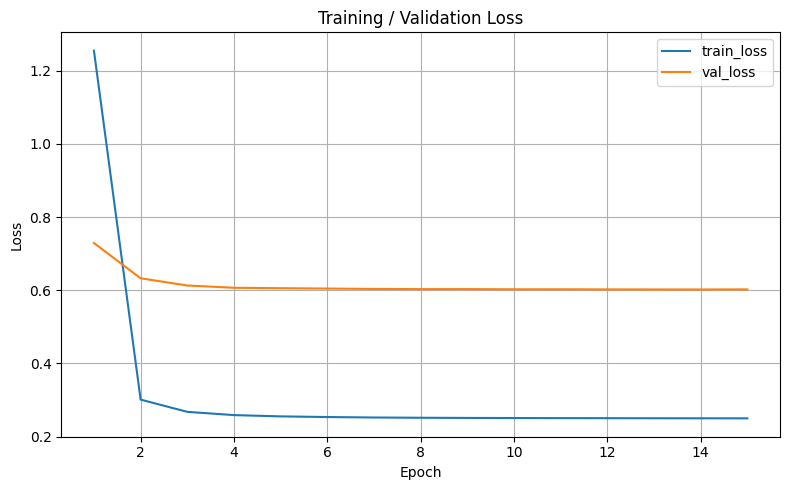

<Figure size 640x480 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, label="train_loss")
plt.plot(range(1, epochs + 1), val_losses, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig("loss_curve.png")

In [41]:
example_prompt = (
    "money=5000\n"
    "winning=1,2,3,4,5,6\n"
    "bonus=7\n"
    "###\n"
    "티켓수=5\n"
    "구매번호:\n"
    "[1,2,3,4,5,6]\n"
)

print("prompt len (tokens):", tokenizer(example_prompt, return_tensors="pt")["input_ids"].shape)
print("model max_len:", model.config.max_len)

generated = generate_text(model, tokenizer, example_prompt, max_new_tokens=512, device=device)
print("=== SAMPLE GENERATION ===")
print(generated)

prompt len (tokens): torch.Size([1, 65])
model max_len: 512
=== SAMPLE GENERATION ===
money=5000
winning=1,2,3,4,5,6
bonus=7
###
티켓수=5
구매번호:
[1,2,3,4,5,6]
[11,13,19,27,36,43]
[13,27,29,40,41,45]
[8,11,13,21,28,41]
[12,20,23,33,35,40]
3개일치 (5000원) = 1
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=100.0%


In [23]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

model = MiniGPT(config).to(device)

# 체크포인트 로드 (파일 이름 맞게 수정 가능)
ckpt_path = "lotto_gpt_best.pt"   # 또는 "lotto_gpt_epoch030.pt" 등
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)

model.eval()
print("checkpoint loaded from:", ckpt_path)

device: cuda
checkpoint loaded from: lotto_gpt_best.pt


In [24]:
example_prompt = (
    "money=1000\n"
    "winning=1,2,3,4,5,6\n"
    "bonus=7\n"
    "###\n"
)

print("prompt len (tokens):", tokenizer(example_prompt, return_tensors="pt")["input_ids"].shape)
print("model max_len:", model.config.max_len)

generated = generate_text(model, tokenizer, example_prompt, max_new_tokens=512, device=device)
print("=== SAMPLE GENERATION ===")
print(generated)

prompt len (tokens): torch.Size([1, 25])
model max_len: 512


=== SAMPLE GENERATION ===
money=1000
winning=1,2,3,4,5,6
bonus=7
###
티켓수=1
구매번호:
[4,14,18,19,21,36]
3개일치 (5000원) = 0
4개일치 (50000원) = 0
5개일치 (1500000원) = 0
5개보너스일치 (30000000원) = 0
6개일치 (2000000000원) = 0
수익률=0.0%
